# Exploring CPU usage on mybinder.org

I want to collect two bits of information from prometheus:

- total CPU time for a pod
- total run time for a pod

For these, I used two metrics:

- [container_cpu_usage_seconds_total](https://prometheus.mybinder.org/graph?g0.range_input=1h&g0.expr=container_cpu_usage_seconds_total%7Bpod%3D~%22jupyter-.*%22%2Ccontainer%3D%22notebook%22%7D&g0.tab=1)
- [kube_pod_start_time](https://prometheus.mybinder.org/graph?g0.range_input=1h&g0.expr=kube_pod_start_time%7Bpod%3D~%22jupyter-.*%22%7D&g0.tab=1)

Prometheus' timeseries nature makes collecting these a little less straightforward.
Rather than per-pod 'totals', metrics are only instantaneous, and are absent when the pod goes away.

To gather cpu time for pods, I use the [query](https://prometheus.mybinder.org/graph?g0.range_input=1h&g0.expr=max(max_over_time(container_cpu_usage_seconds_total%7Bpod%3D~%22jupyter-.*%22%2Ccontainer%3D%22notebook%22%7D%5B1h%5D))%20by%20(pod)&g0.tab=1):

    max(max_over_time(container_cpu_usage_seconds_total{pod=~"jupyter-.*",container="notebook"}[4h])) by (pod)

This takes the max value for `container_cpu_usage_seconds_total` found for each pod within a given window.
This will include samples for any pods that were running at any time in this window.
It *will* include pods that have not finished, producing an underestimate of cpu usage.
Collecting data over several intervals and picking the max value for a pod across intervals
means that only a subset of pods in the last window will be incomplete,
resulting in a small underestimation of cpu time depending on the total window size.

Getting pod age is a little more wonky because prometheus does not record pod age or deletion time,
records about the pods just go away.
(There is a pod_completion_time, which I tried first, but very few pods include this.
Likely because we delete pods immediately rather than leaving them in a completed state).

To find pod age, I used the fact that prometheus drops records for nonexistent pods, and used the [query](https://prometheus.mybinder.org/graph?g0.range_input=1h&g0.expr=kube_pod_start_time%7Bpod%3D~%22jupyter-.*%22%7D%5B4h%5D&g0.tab=1):

    kube_pod_start_time{pod=~"jupyter-.*"}[4h]

which produces a series like:

```
1612414404 @1612414429.654
1612414404 @1612414489.654
1612414404 @1612414549.654
1612414404 @1612414609.654
1612414404 @1612414669.654
1612414404 @1612414729.654
1612414404 @1612414789.654
1612414404 @1612414849.655
1612414404 @1612414909.654
1612414404 @1612414969.654
1612414404 @1612415029.654
```

where every sample will have the same value (the start time of the pod), but there will only be samples at timestamps where the pod still exists.
So we can get the pod start time from any sample, and use the latest available sample timestamp as the end time.

We can eliminate data for incomplete pods by:

- setting our end time more than one idle-cull interval ago (e.g. now - 7 hours)
- collect start/end time data one slice beyond our end time, and discard data for any pods still around
  after our end time

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from prometheus_api_client import PrometheusConnect

In [2]:
url = "https://prometheus.mybinder.org"
prom = PrometheusConnect(url=url)

In [3]:
[metric_name for metric_name in prom.all_metrics() if 'cpu' in metric_name]

['container_cpu_cfs_periods_total',
 'container_cpu_cfs_throttled_periods_total',
 'container_cpu_cfs_throttled_seconds_total',
 'container_cpu_load_average_10s',
 'container_cpu_system_seconds_total',
 'container_cpu_usage_seconds_total',
 'container_cpu_user_seconds_total',
 'container_spec_cpu_period',
 'container_spec_cpu_quota',
 'container_spec_cpu_shares',
 'go_memstats_gc_cpu_fraction',
 'kube_node_status_allocatable_cpu_cores',
 'kube_node_status_capacity_cpu_cores',
 'kube_pod_container_resource_limits_cpu_cores',
 'kube_pod_container_resource_requests_cpu_cores',
 'machine_cpu_cores',
 'nginx_ingress_controller_nginx_process_cpu_seconds_total',
 'node_cpu_guest_seconds_total',
 'node_cpu_seconds_total',
 'node_memory_Percpu_bytes',
 'process_cpu_seconds_total']

In [4]:
duration = dt.timedelta(hours=1)
end_time = dt.datetime.now(tz=dt.timezone.utc) - dt.timedelta(hours=7)
start_time = end_time - duration
step = "1h"
query_args = dict(
    start_time=start_time,
    end_time=end_time,
    step=step,
)


Test our queries to see what the data looks like

In [5]:
prom.custom_query_range(
    'max(max_over_time(container_cpu_usage_seconds_total{pod=~"jupyter-.*",container="notebook"}[4h])) by (pod)',
    **query_args
)[:5]

[{'metric': {'pod': 'jupyter-10-2e5281-2dzenodo-2e3519348-2dphosqp4u'},
  'values': [[1612413989, '1.869217657']]},
 {'metric': {'pod': 'jupyter-10-2e5281-2dzenodo-2e4455260-2dhhgdcif9'},
  'values': [[1612410389, '1.723101428'], [1612413989, '1.723101428']]},
 {'metric': {'pod': 'jupyter-10-2e5281-2dzenodo-2e4495953-2d6l5dkz16'},
  'values': [[1612410389, '259.707630547'], [1612413989, '259.707630547']]},
 {'metric': {'pod': 'jupyter-10-2e5281-2dzenodo-2e4495999-2dznjzs4ie'},
  'values': [[1612410389, '1.921824792'], [1612413989, '1.921824792']]},
 {'metric': {'pod': 'jupyter-1010code-2diris-2ddnn-2dtensorflow-2drchh2x68'},
  'values': [[1612413989, '3.447918273']]}]

In [6]:
prom.custom_query(
    'kube_pod_start_time{pod=~"jupyter-.*"}[4h]',
    params={"time": end_time.timestamp()},
)[:2]

[{'metric': {'__name__': 'kube_pod_start_time',
   'app_kubernetes_io_instance': 'prod',
   'app_kubernetes_io_managed_by': 'Helm',
   'app_kubernetes_io_name': 'kube-state-metrics',
   'helm_sh_chart': 'kube-state-metrics-2.8.14',
   'instance': '10.0.2.10:8080',
   'job': 'kubernetes-service-endpoints',
   'kubernetes_name': 'prod-kube-state-metrics',
   'kubernetes_namespace': 'prod',
   'kubernetes_node': 'gke-prod-user-202009-b9c03ca0-giwo',
   'namespace': 'prod',
   'pod': 'jupyter-10-2e5281-2dzenodo-2e3519348-2dphosqp4u'},
  'values': [[1612412869.654, '1612412810'],
   [1612412929.654, '1612412810'],
   [1612412989.654, '1612412810'],
   [1612413049.654, '1612412810'],
   [1612413109.654, '1612412810'],
   [1612413169.654, '1612412810'],
   [1612413229.654, '1612412810'],
   [1612413289.654, '1612412810'],
   [1612413349.654, '1612412810'],
   [1612413409.654, '1612412810'],
   [1612413469.654, '1612412810'],
   [1612413529.654, '1612412810'],
   [1612413589.654, '1612412810']


## Data collection


Now we can collect our data by running these queries over our time window and extract the data:

- pod name comes from metric.pod
- cpu_seconds is max(container_cpu_usage_seconds_total) seen on interval per pod
- start_time comes from any pod_start_time sample
- end_time is timestamp of last start_time sample (underestimated on average by 1/2 time step)
- discard pods wth end_time outside our window
- age is end_time - start_time

In [7]:
from collections import defaultdict

def collect_data(duration=dt.timedelta(hours=4), step='4h'):
    assert step.endswith("h")
    max_pod_age = dt.timedelta(hours=7)
    end_time = dt.datetime.now(tz=dt.timezone.utc) - max_pod_age
    end_timestamp = end_time.timestamp()
    start_time = end_time - duration
    query_args = dict(
        start_time=start_time,
        end_time=end_time,
        step=step,
    )

    print("Fetching cpu usage")
    cpu_results = prom.custom_query_range(
        query='max(max_over_time(container_cpu_usage_seconds_total{pod=~"jupyter-.*",container="notebook"}[%s])) by (pod)' % step,
        **query_args,
    )
    print(f"Fetched {len(cpu_results)} cpu results")

    pods = defaultdict(lambda: {"cpu_seconds": None, "start_time": None, "end_time": None})
    for result in cpu_results:
        pod_name = result['metric']['pod']
        for ts, value_str in result['values']:
            info = pods[pod_name]
            value = float(value_str)
            if not info["cpu_seconds"]:
                info["cpu_seconds"] = value
            else:
                info["cpu_seconds"] = max(value, info["cpu_seconds"])
    
    print("Fetching start times")
    window = dt.timedelta(hours=int(step.rstrip('h')))

    # start sampling times one slice after end_time
    # so we can discard pods not completed within our interval
    sample_time = end_time + window
    while sample_time >= start_time:
        start_times = prom.custom_query(
            'kube_pod_start_time{pod=~"jupyter-.*"}[%s]' % step,
            params={"time": sample_time.timestamp()},
        )
        print(f"Fetched {len(start_times)} start times for {sample_time}")

        for result in start_times:
            pod_name = result['metric']['pod']
            pod_end_time, pod_start_time_s = result['values'][-1]
            pod_start_time = int(pod_start_time_s)
            if pod_start_time > end_timestamp:
                # pod started after our window, ignore it
                continue
            pod_end_time = int(pod_end_time)
            info = pods[pod_name]
            if not info["start_time"]:
                info["start_time"] = pod_start_time
            if not info["end_time"]:
                info["end_time"] = pod_end_time
            else:
                info["end_time"] = max(pod_end_time, info["end_time"])

        sample_time -= window
    

    df = pd.DataFrame.from_dict(pods, orient='index')
    too_late = df.end_time > (end_timestamp + 1)
    print(f"Dropping pods still running after {end_time}: {too_late.sum()}")
    df = df[~too_late]

    print(f"Dropping records with missing data: {df.isna().sum()}")
    df = df.dropna()
    df["age"] = df.end_time - df.start_time
    df.start_time = pd.to_datetime(df.start_time, unit='s')
    df.end_time = pd.to_datetime(df.end_time, unit='s')
    return df

df = collect_data(duration=dt.timedelta(days=28), step="6h")
len(df)

Fetching cpu usage
Fetched 442189 cpu results
Fetching start times
Fetched 6344 start times for 2021-02-04 10:46:30.573717+00:00
Fetched 3090 start times for 2021-02-04 04:46:30.573717+00:00
Fetched 5646 start times for 2021-02-03 22:46:30.573717+00:00
Fetched 7928 start times for 2021-02-03 16:46:30.573717+00:00
Fetched 6125 start times for 2021-02-03 10:46:30.573717+00:00
Fetched 3031 start times for 2021-02-03 04:46:30.573717+00:00
Fetched 5429 start times for 2021-02-02 22:46:30.573717+00:00
Fetched 8724 start times for 2021-02-02 16:46:30.573717+00:00
Fetched 5790 start times for 2021-02-02 10:46:30.573717+00:00
Fetched 3168 start times for 2021-02-02 04:46:30.573717+00:00
Fetched 5343 start times for 2021-02-01 22:46:30.573717+00:00
Fetched 8221 start times for 2021-02-01 16:46:30.573717+00:00
Fetched 6042 start times for 2021-02-01 10:46:30.573717+00:00
Fetched 3136 start times for 2021-02-01 04:46:30.573717+00:00
Fetched 4925 start times for 2021-01-31 22:46:30.573717+00:00
Fet

439248

In [8]:
df

,cpu_seconds,start_time,end_time,age
jupyter-0consequence-2dbinder-2de5te4sbl,1.722308,2021-01-25 22:59:03,2021-01-25 23:41:45,2562.0
jupyter-0consequence-2dbinder-2dm0uwrqen,2.078115,2021-02-01 06:42:39,2021-02-01 06:57:49,910.0
jupyter-0consequence-2dbinder-2dnhwnd6tm,1.559423,2021-01-25 22:56:59,2021-01-25 23:08:45,706.0
jupyter-0consequence-2dbinder-2dzthuqfhd,2.506064,2021-01-25 22:47:59,2021-01-25 23:37:45,2986.0
jupyter-0hughman0-2dunscrabbler-2d0lzor6nd,8.069652,2021-02-02 13:58:55,2021-02-02 14:13:49,894.0
...,...,...,...,...
jupyter-zz4fap-2dt319-5fapr-2dzado-5fde-5fmaquina-2dqs1zsi0t,3.078337,2021-01-27 11:37:54,2021-01-27 11:49:45,711.0
jupyter-zz4fap-2dt319-5fapr-2dzado-5fde-5fmaquina-2dtciwzbv2,3.290304,2021-01-29 14:51:18,2021-01-29 15:07:45,987.0
jupyter-zz4fap-2dt319-5fapr-2dzado-5fde-5fmaquina-2dulbq3c8q,112.082388,2021-01-27 11:34:09,2021-01-27 11:49:45,936.0
jupyter-zz4fap-2dt319-5fapr-2dzado-5fde-5fmaquina-2dvkbxly3l,2.852571,2021-02-01 16:36:14,2021-02-01 16:48:49,755.0


Plotting [cumulative density functions](https://en.wikipedia.org/wiki/Cumulative_distribution_function) let us see
"what fraction of pods use at least X cpu-seconds"

We can also present the same data in two tables:

- quantiles (taking samples along y-axis, allowing us to answer "how much cpu do Y% of users use?")
- histogram (taking samples along x-axis, allowing us to answer "what fraction of users use more than X cpu-minutes?")

In [9]:
from IPython.display import HTML, display

In [10]:
import numpy as np
m = 60
h = 60 * m

age_bins = [0, 15 * m, 30 * m, h, 2 * h, 4 * h, 6 * h, np.inf]
cpu_bins = [0, 10, 1 * m, 10 * m, 30 * m, h, 2 * h, np.inf]

def print_histogram(df, which="cpu", label=''):
    """Print a histogram
    
    Like the transpose of percentiles
    
    instead of 50% have age <= 1:21, show
    age >= 1m: 23%
    """
    print(f"Histogram for {which} ({label})")
    if which == "age":
        bins = age_bins
        column = "age"
    elif which == "cpu":
        bins = cpu_bins
        column = "cpu_seconds"
    else:
        raise ValueError("which must be age or cpu")
    
    hist, bins = np.histogram(df[column], bins=bins)
    hist_percent = 100 - (100 * hist / hist.sum()).cumsum()
    lines = [
        "<table>"
        f"<tr><th>{which} ≥</th><th>percent</th><th>count</th></tr>"
    ]
    for lte, p, count in zip(bins[1:-1], hist_percent[:-1], hist[:-1]):
        if not (0.09 < p < 99.9):
            continue
        lines.append(f"<tr><td>{dt.timedelta(seconds=int(lte))}</td><td>{p:4.1f}%</td><td>{count}</td></tr>")
    lines.append("</table>")
    display(HTML("\n".join(lines)))

    
print_histogram(df)

Histogram for cpu ()


cpu ≥,percent,count
0:00:10,41.5%,256984
0:01:00,5.8%,156838
0:10:00,1.2%,20125
0:30:00,0.5%,2987
1:00:00,0.3%,1156
2:00:00,0.1%,656


Percentiles for all pods (N% pods have age ≤ .., use cpu ≤ ...): 439248 total pods


,age,cpu
percentile,,
0.50,00:14:11,00:00:06
0.80,00:32:32,00:00:20
0.90,00:50:58,00:00:33
0.99,03:08:21,00:13:29


Histogram for age (all pods)


age ≥,percent,count
0:15:00,46.8%,233599
0:30:00,22.4%,107267
1:00:00,7.6%,64903
2:00:00,2.2%,23756
4:00:00,0.7%,6689
6:00:00,0.4%,1427


Histogram for cpu (all pods)


cpu ≥,percent,count
0:00:10,41.5%,256984
0:01:00,5.8%,156838
0:10:00,1.2%,20125
0:30:00,0.5%,2987
1:00:00,0.3%,1156
2:00:00,0.1%,656


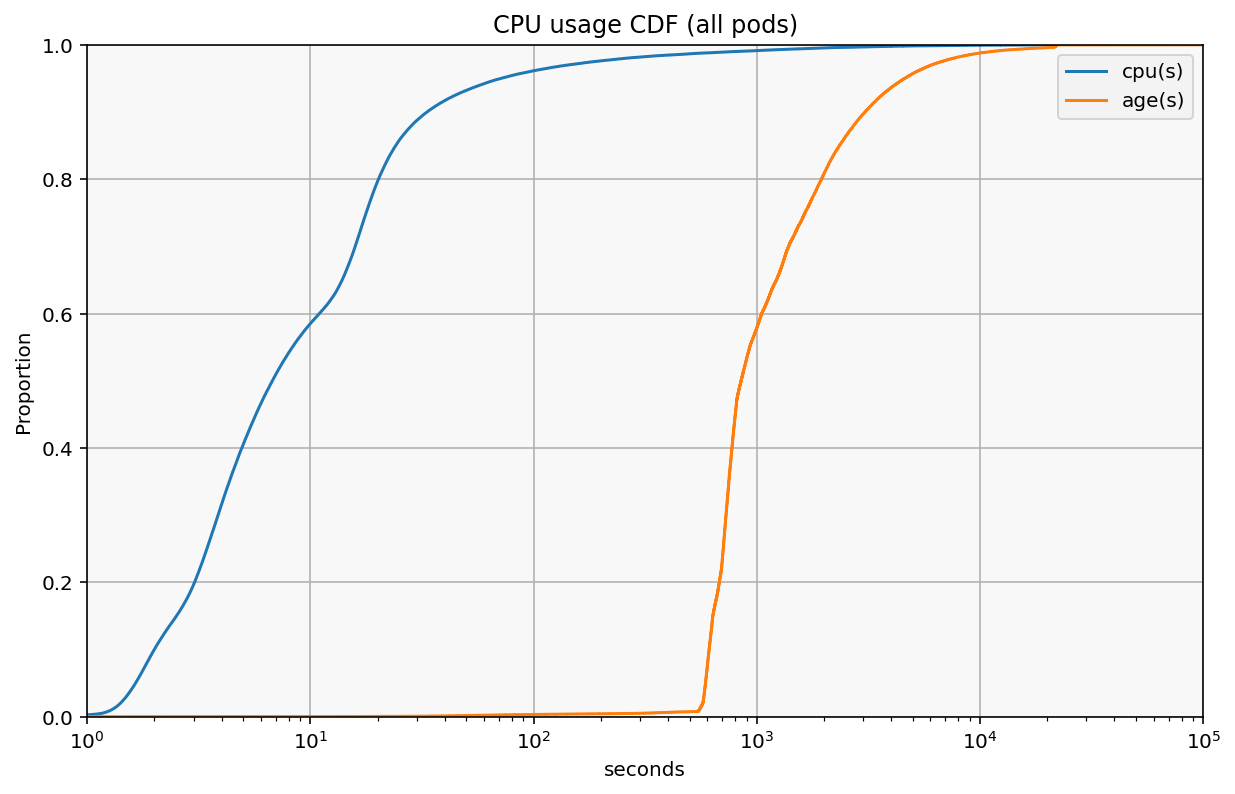

In [15]:
def fmt_timedelta(series):
    """Format a series of seconds as nice timedelta strings"""
    return pd.to_timedelta(series, unit="s").dt.components.apply(lambda row: f"{row.hours:02}:{row.minutes:02}:{row.seconds:02}", axis=1)

def plot_cdf(data, label=''):
    """Plot and summarize CDF
    
    - plot empircal CDF with seaborn
    - Display tables for
      - quantiles of age, cpu
      - histogram of age
      - histogram of cpu
    """
    sns.ecdfplot(data=data, x="cpu_seconds")
    sns.ecdfplot(data=data, x="age")
    plt.legend(["cpu(s)", "age(s)"], loc=0)
    print(f"Percentiles for {label} (N% pods have age ≤ .., use cpu ≤ ...): {len(data)} total pods")
    quantiles = data.quantile([0.5, 0.8, 0.9, 0.99])
    quantiles.index.name = "percentile"
    quantiles["age"] = fmt_timedelta(quantiles.age)
    quantiles["cpu"] = fmt_timedelta(quantiles.pop("cpu_seconds"))
    display(quantiles)

        
    print_histogram(data, "age", label)
    print_histogram(data, "cpu", label)

    plt.title(f"CPU usage CDF ({label})")
    plt.xscale("log")
    plt.xlim(1, 1e5)
    plt.xlabel("seconds")

plot_cdf(df, "all pods")

We can now view the same summary report for subsets of sessions,
e.g. exclude very short or unused sessions by only looking at age > 20m:

Percentiles for age > 20m (N% pods have age ≤ .., use cpu ≤ ...): 156490 total pods


,age,cpu
percentile,,
0.50,00:34:59,00:00:17
0.80,01:02:28,00:00:37
0.90,01:32:24,00:01:31
0.99,06:00:20,00:46:01


Histogram for age (age > 20m)


age ≥,percent,count
0:30:00,62.9%,58108
1:00:00,21.4%,64903
2:00:00,6.2%,23756
4:00:00,1.9%,6689
6:00:00,1.0%,1427


Histogram for cpu (age > 20m)


cpu ≥,percent,count
0:00:10,67.4%,50945
0:01:00,13.5%,84435
0:10:00,3.2%,16033
0:30:00,1.5%,2763
1:00:00,0.7%,1156
2:00:00,0.3%,656


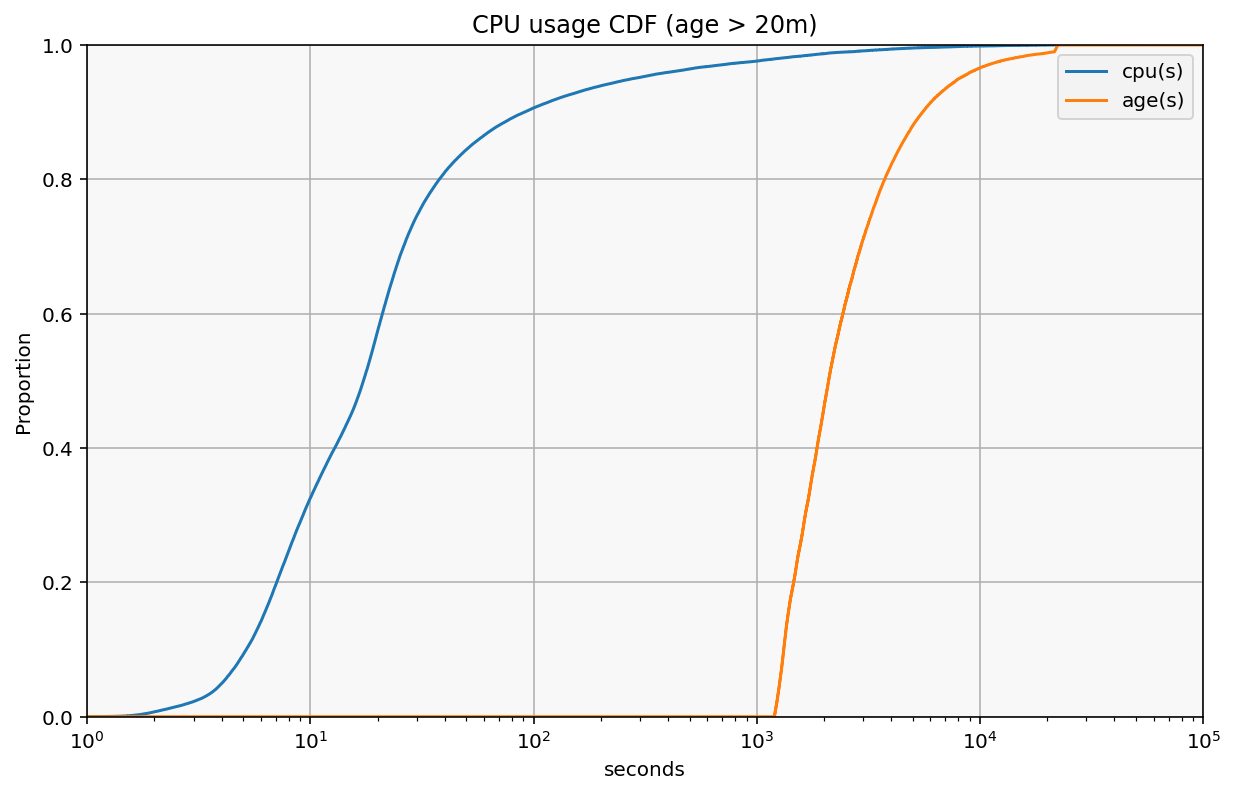

In [16]:
plot_cdf(df[df.age >= 20 * 60], label="age > 20m")

And only "long" sessions (age > 1hr)

Percentiles for age > 1h (N% pods have age ≤ .., use cpu ≤ ...): 33479 total pods


,age,cpu
percentile,,
0.50,01:29:02,00:00:36
0.80,02:27:38,00:02:18
0.90,03:44:09,00:11:16
0.99,06:09:09,02:30:15


Histogram for age (age > 1h)


age ≥,percent,count
2:00:00,29.0%,23756
4:00:00,9.1%,6689
6:00:00,4.8%,1427


Histogram for cpu (age > 1h)


cpu ≥,percent,count
0:00:10,93.3%,2243
0:01:00,33.0%,20176
0:10:00,10.5%,7544
0:30:00,6.1%,1490
1:00:00,3.4%,876
2:00:00,1.5%,648


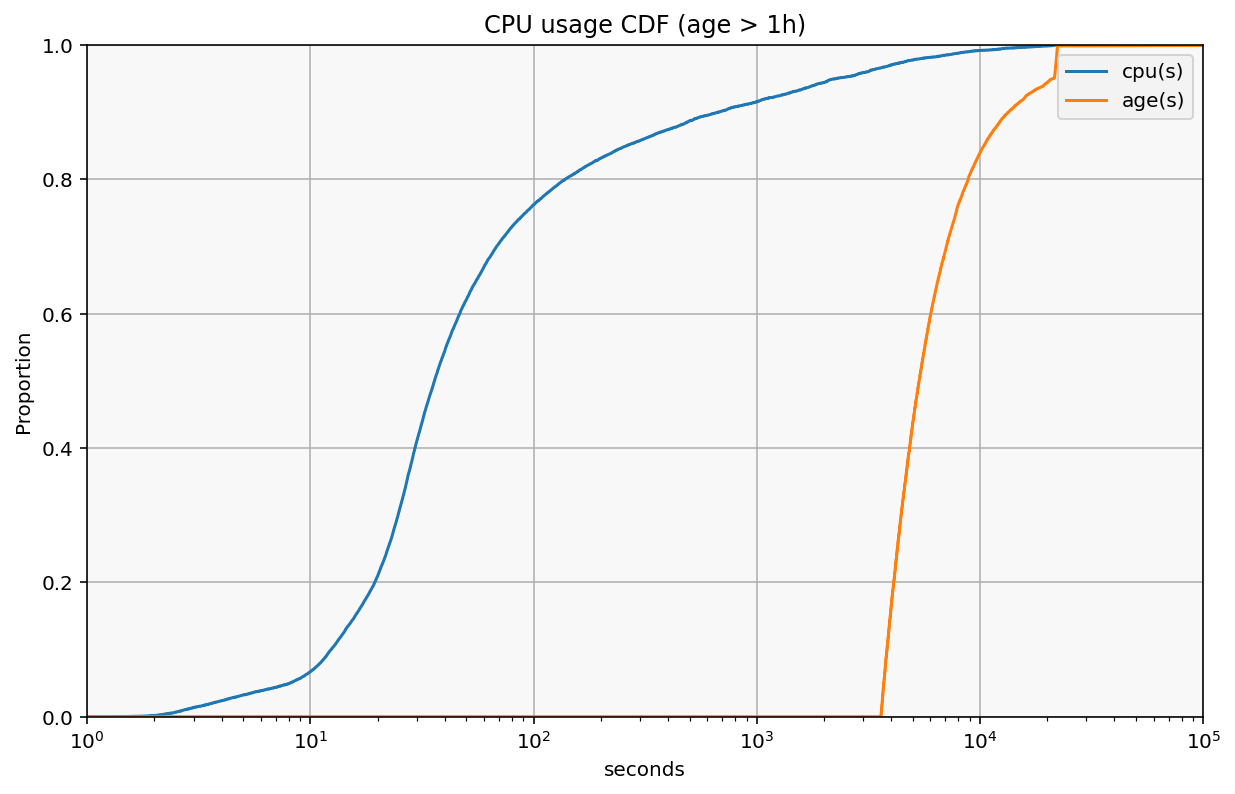

In [17]:
plot_cdf(df[df.age >= 1 * h], label="age > 1h")

We can also limit to only the "busy" pods (e.g. using more than 10 cpu-minutes)

Percentiles for cpu > 10m (N% pods have age ≤ .., use cpu ≤ ...): 5301 total pods


,age,cpu
percentile,,
0.50,01:34:24,00:26:07
0.80,04:12:34,01:04:37
0.90,06:00:56,01:54:04
0.99,06:10:13,05:45:10


Histogram for age (cpu > 10m)


age ≥,percent,count
0:15:00,98.9%,58
0:30:00,87.8%,587
1:00:00,66.3%,1140
2:00:00,41.5%,1316
4:00:00,20.8%,1099
6:00:00,10.7%,532


Histogram for cpu (cpu > 10m)


cpu ≥,percent,count
0:30:00,43.7%,2987
1:00:00,21.8%,1156
2:00:00,9.5%,656


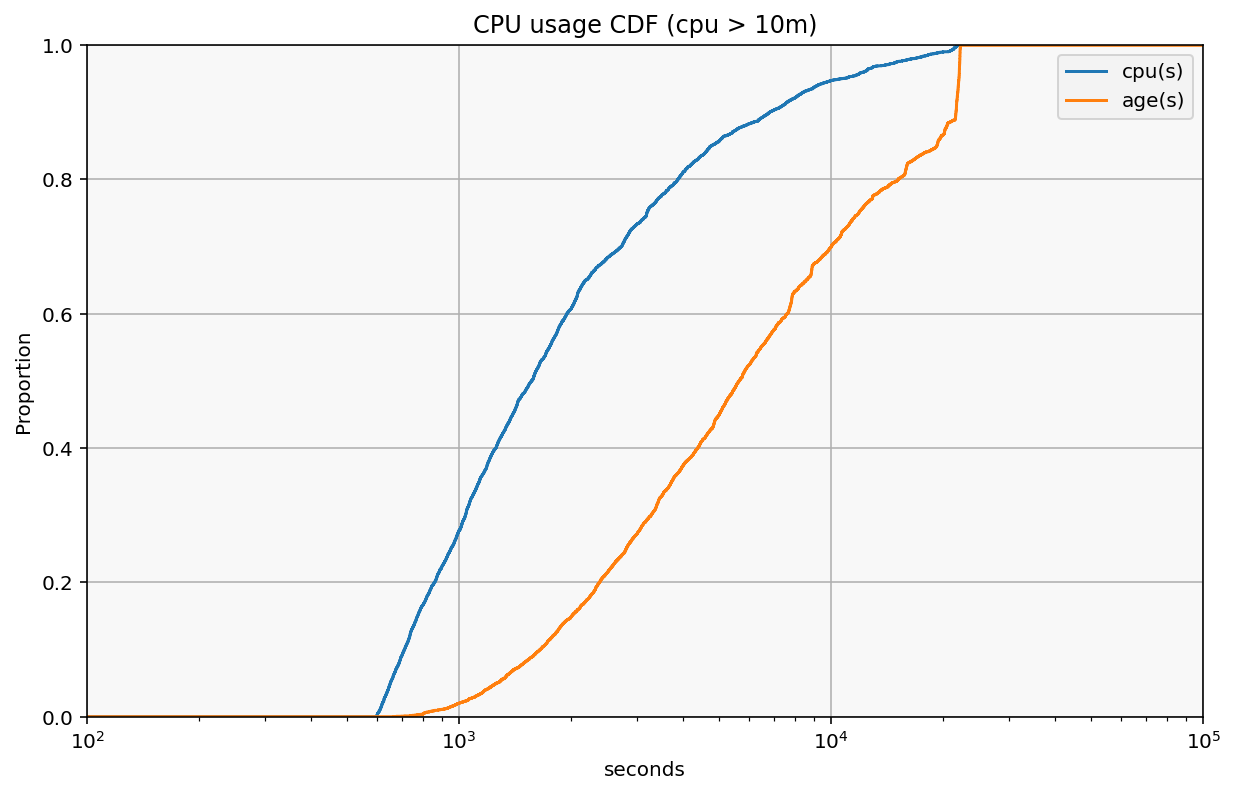

In [19]:
plot_cdf(df[df.cpu_seconds >= 600], label="cpu > 10m")
plt.xlim(1e2, 1e5);